# About this notebook
This notebook is adapted from the original notebook of the Stardist repository for 3D segmentation found [here](https://github.com/stardist/stardist/tree/master/examples/3D)

## NOTE
I converted this notebook to a simple `training.py` file because JupyterHub kernel kept crushing during training. There is no functional difference between the notebook or the py script. I did it just so that I could run the py script from terminal without the notebook crashing.

In [1]:
# Import packages
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import os
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

from skimage.transform import resize

In [2]:
# Define paths
img_path = '../../../data/'
label_path = '../../../processing/Output/S**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).img_path + '*H4/*DAPI.TIF') if "SR" not in path if "neg" not in path if "Temp" not in path if "LiveSr" not in path])
label_paths = sorted(glob(label_path + '*'))

# Check that for each image we have annotations!
assert len(label_paths) == len(img_paths), "Images and labels don't correspond!"

In [3]:
# Check for correspondence between data and annotations
for idx in range(len(img_paths)):
    print(os.path.basename(img_paths[idx]), '-->' ,os.path.basename(img_paths[idx]))

    
# Images are too large as they are -> we need to resize them
# Resizing factor of 4 is the min we need for the FOV of the network to cover our objects
resizing_factor = 4

# As we open load the images, we resize them directly
# We only resize in X and Y dimensions as in Z they are small enough
X, Y = [], []
for img, label in zip(img_paths, label_paths):
    temp = imread(img)
    resized_temp = resize(temp, (temp.shape[0], temp.shape[1] / resizing_factor, temp.shape[2] / resizing_factor), anti_aliasing=True, preserve_range=True, mode='constant')
    X.append(resized_temp)
    
    temp = imread(label)
    resized_temp = resize(temp, (temp.shape[0], temp.shape[1] / resizing_factor, temp.shape[2] / resizing_factor), anti_aliasing=False, preserve_range=False, order=0, mode='constant').astype('uint16')
    Y.append(resized_temp)
    
# Check that we have same amount of raw images and annotations after loading and resizing
print(len(X), len(Y))

Auxin_1_w1SPI 405 DAPI.TIF --> Auxin_1_w1SPI 405 DAPI.TIF
Auxin_2_w1SPI 405 DAPI.TIF --> Auxin_2_w1SPI 405 DAPI.TIF
crtl-1_w1SPI 405 DAPI.TIF --> crtl-1_w1SPI 405 DAPI.TIF
crtl-2_w1SPI 405 DAPI.TIF --> crtl-2_w1SPI 405 DAPI.TIF
Auxin_1_w2SPI 405 DAPI.TIF --> Auxin_1_w2SPI 405 DAPI.TIF
Auxin_2_w2SPI 405 DAPI.TIF --> Auxin_2_w2SPI 405 DAPI.TIF
Auxin_3_w2SPI 405 DAPI.TIF --> Auxin_3_w2SPI 405 DAPI.TIF
Auxin_5_w2SPI 405 DAPI.TIF --> Auxin_5_w2SPI 405 DAPI.TIF
crtl_1_w1SPI 405 DAPI.TIF --> crtl_1_w1SPI 405 DAPI.TIF
crtl_2_w2SPI 405 DAPI.TIF --> crtl_2_w2SPI 405 DAPI.TIF
crtl_3_w2SPI 405 DAPI.TIF --> crtl_3_w2SPI 405 DAPI.TIF
crtl_4_w2SPI 405 DAPI.TIF --> crtl_4_w2SPI 405 DAPI.TIF
12 12


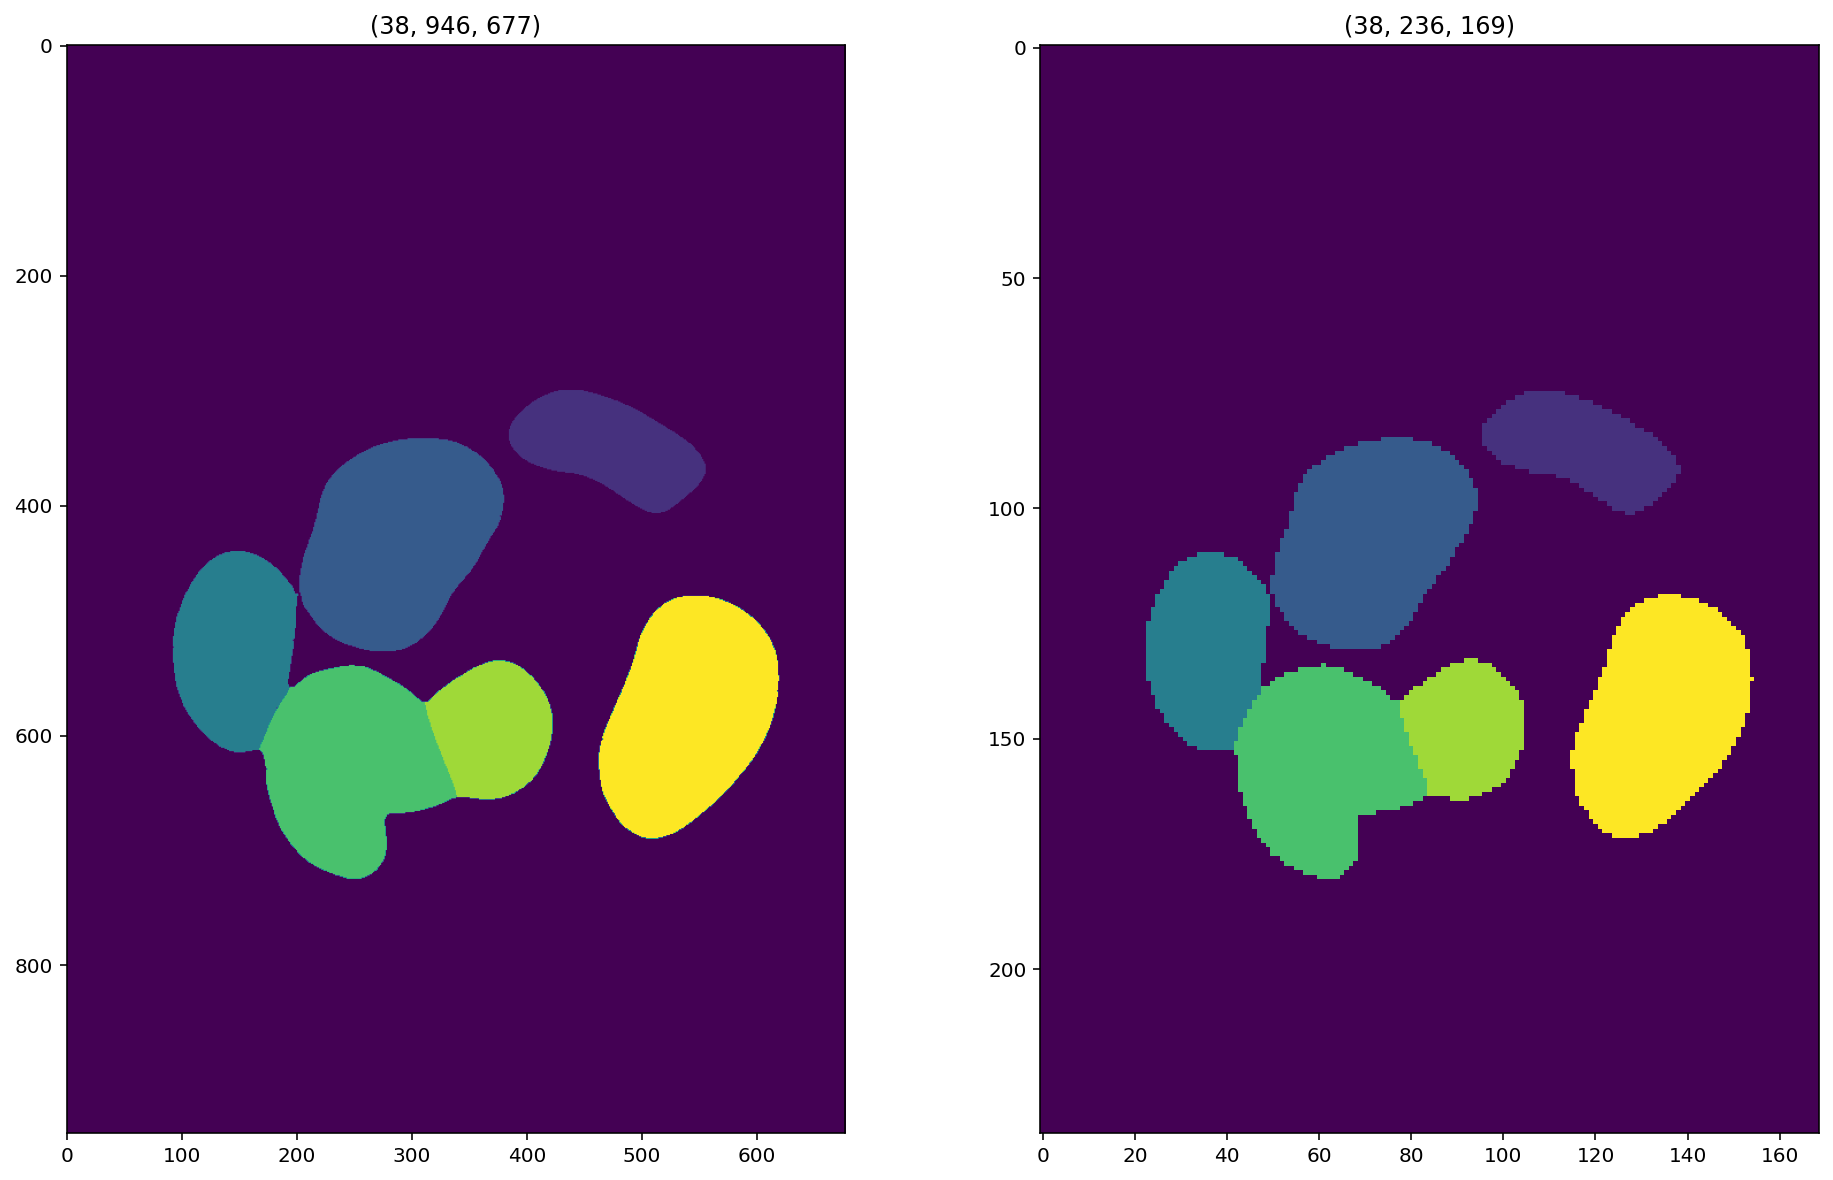

In [21]:
# Visualize resizing
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,10))
ax1.imshow(temp[int(temp.shape[0] / 2)])
ax1.set_title(temp.shape)
ax2.imshow(Y[-1][int(Y[-1].shape[0] / 2)])
ax2.set_title(Y[-1].shape)
plt.show()

Normalize images and fill small label holes.

In [4]:
# Normalize intensity of images as from Stardist original notebook
# also fill holes of annotations

axis_norm = (0,1,2)   # normalize channels independently

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 12/12 [00:00<00:00, 36.02it/s]


Split into train and validation datasets.

In [5]:
# Split between training and validation datasets
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  12
- training:        10
- validation:       2


Training data consists of pairs of input image and label instances.

In [12]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z])
    al.set_title(lbl_title)
    plt.tight_layout()

In [25]:
i = 0
img, lbl = X[i], Y[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)
None;

In [6]:
# Get anisotropy of the new resized images
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (2.048076923076923, 1.0047169811320755, 1.0)


In [27]:
# 96 is a good default choice
n_rays = 96 # actually 128 would be better

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True

# Set the grid to match the FOV of network
grid = (1,4,4)
n_channel = 1

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

# Initialize model
conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (16,96,96),
    train_batch_size = 2,
)

#print(conf)
#vars(conf)

Config3D(n_dim=3, axes='ZYXC', n_channel_in=1, n_channel_out=97, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=96, grid=(1, 4, 4), anisotropy=(2.048076923076923, 1.0047169811320755, 1.0), backbone='unet', rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (2.048076923076923, 1.0047169811320755, 1.0)}}, n_classes=None, unet_n_depth=2, unet_kernel_size=(3, 3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), train_patch_size=(16, 96, 96), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_r

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 97,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 96,
 'grid': (1, 4, 4),
 'anisotropy': (2.048076923076923, 1.0047169811320755, 1.0),
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 96,
   'anisotropy': (2.048076923076923, 1.0047169811320755, 1.0)}},
 'n_classes': None,
 'unet_n_depth': 2,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (16, 96, 96),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae'

In [11]:
# Don't think we need this
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    # limit_gpu_memory(0.8)
    # alternatively, try this:
    limit_gpu_memory(None, allow_growth=True)

In [7]:
# Create model --> here you will get errors if the GPU doesn't work properly
model = StarDist3D(conf, name='stardist_faezeh', basedir='models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.253127, nms_thresh=0.3.


2023-03-15 12:57:18.189316: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 12:57:18.562707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18197 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:25:00.0, compute capability: 8.0


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [14]:
# Verify that the objects are within the FOV size and not too large
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2023-03-15 10:36:54.622625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-15 10:36:55.270490: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2023-03-15 10:36:55.794333: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 10:36:55.795495: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 10:36:55.795512: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-03-15 10:36:55.796124: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 10:36:55.796178: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

median object size:      [26.   53.   53.25]
network field of view :  [26 93 93]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (3D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [15]:
def random_fliprot(img, mask, axis=None): 
    if axis is None:
        axis = tuple(range(mask.ndim))
    axis = tuple(axis)
            
    assert img.ndim>=mask.ndim
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(mask.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    img = img.transpose(transpose_axis + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(transpose_axis) 
    for ax in axis: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Note that we only use fliprots along axis=(1,2), i.e. the yx axis 
    # as 3D microscopy acquisitions are usually not axially symmetric
    x, y = random_fliprot(x, y, axis=(1,2))
    x = random_intensity_change(x)
    return x, y


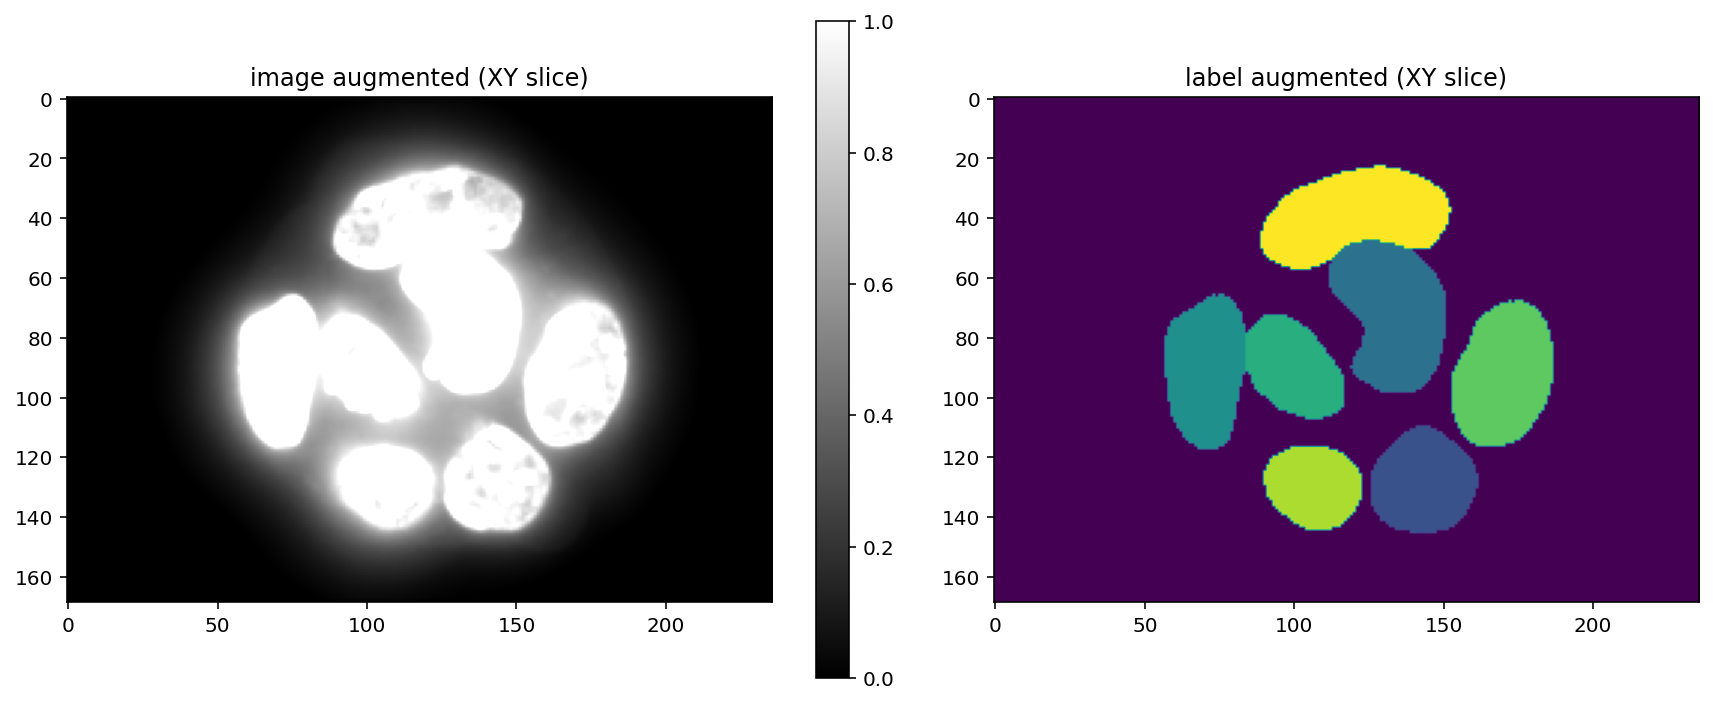

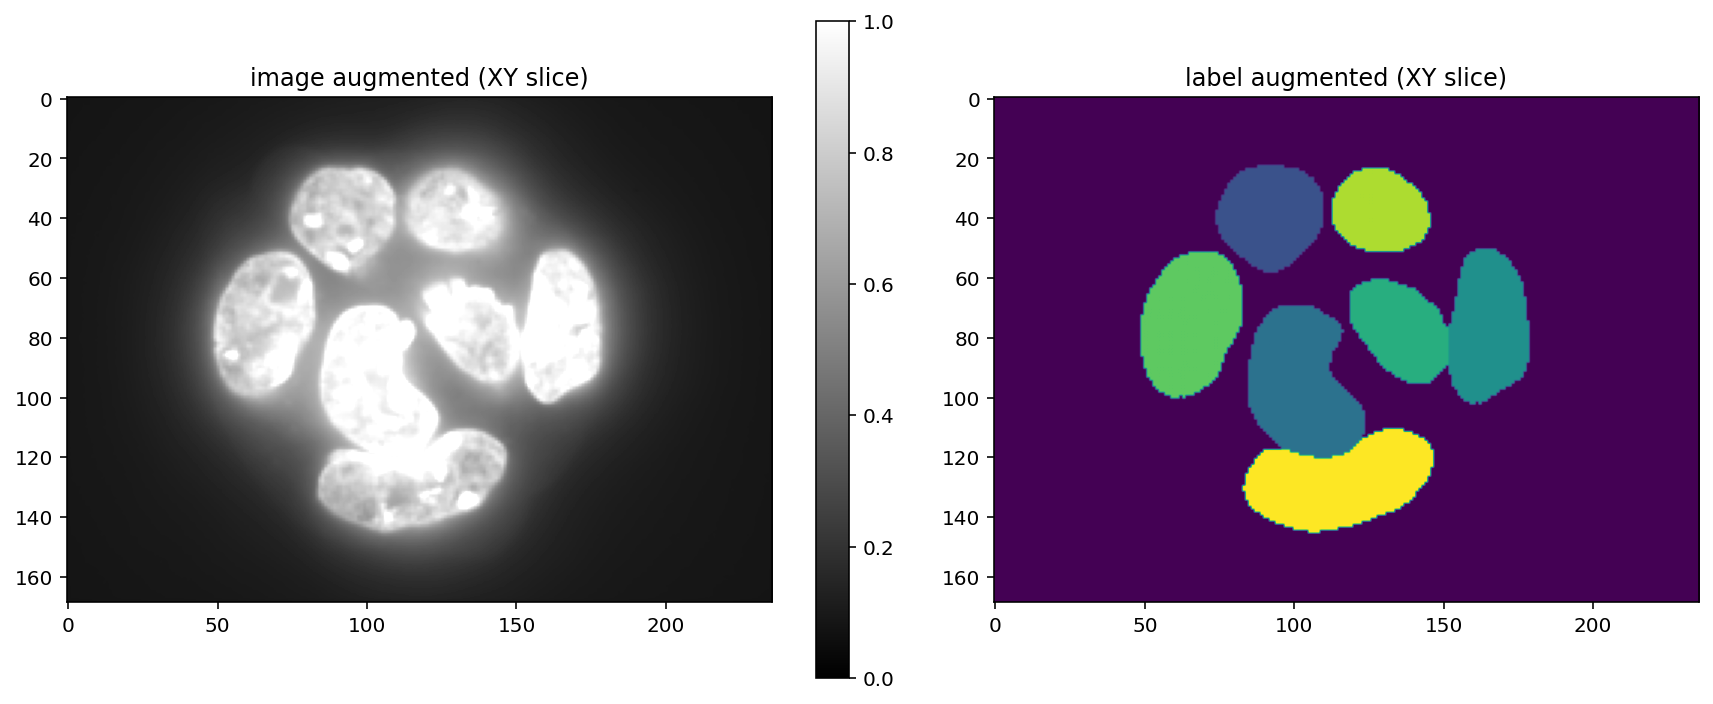

In [16]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

# Training

In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
Epoch 1/400
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x151cb0a0e310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x151cb0a0e310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x151cb0a0e310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 12s 85ms/step - loss: 2.5437 - prob_loss: 0.4632 - dist_loss: 10.4025 - prob_kld: 0.2906 - dist_relevant_mae: 10.4022 - dist_relevant_mse: 180.6415 - dist_dist_iou_metric: 0.0906 - val_loss: 1.6725 - val_prob_loss: 0.2702 - val_dist_loss: 7.0118 - val_prob_kld: 0.1660 - val_di

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [9]:
# optimize thresholds
model.optimize_thresholds(X_val, Y_val)

2023-03-15 12:57:36.109095: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-15 12:57:36.751414: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2023-03-15 12:57:37.279848: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 12:57:37.280608: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 12:57:37.280636: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2023-03-15 12:57:37.281178: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 12:57:37.281232: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

Using optimized values: prob_thresh=0.801769, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.8017694216235479, 'nms': 0.3}

# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [18]:
# help(matching)

First predict the labels for all validation images:

In [10]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=True)[0]
              for x in tqdm(X_val)]

100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Plot a GT/prediction example  

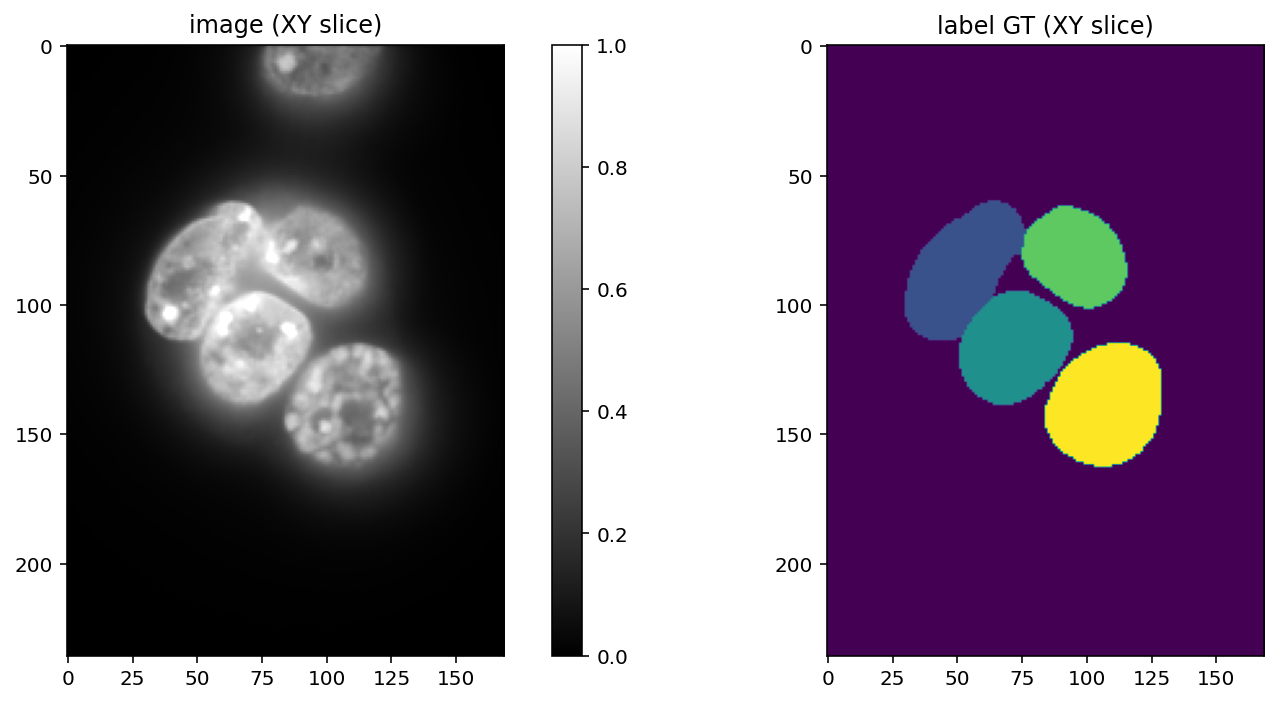

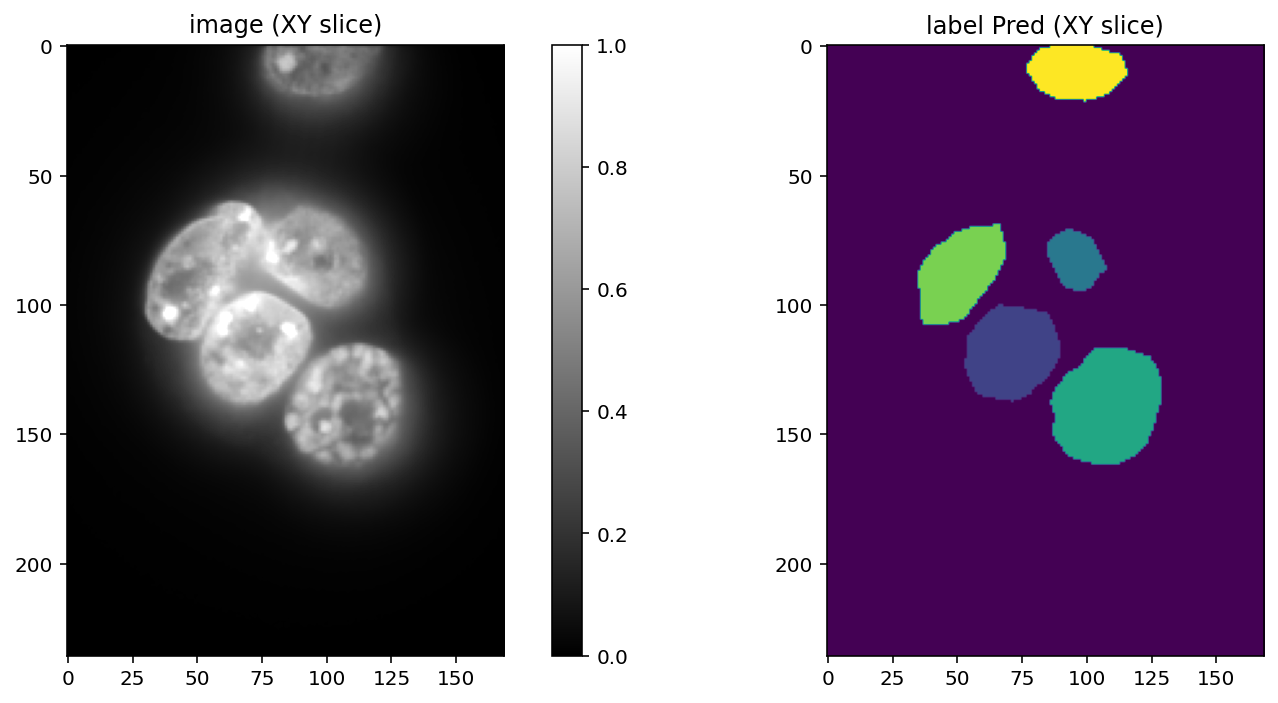

In [15]:
img_id = 1
plot_img_label(X_val[img_id],Y_val[img_id], lbl_title="label GT (XY slice)")
plot_img_label(X_val[img_id],Y_val_pred[img_id], lbl_title="label Pred (XY slice)")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [35]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


Example: Print all available matching statistics for $\tau=0.7$

In [36]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=9, tp=3, fn=9, precision=0.25, recall=0.25, accuracy=0.14285714285714285, f1=0.25, n_true=12, n_pred=12, mean_true_score=0.19079924126466116, mean_matched_score=0.7631969650586446, panoptic_quality=0.19079924126466116, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

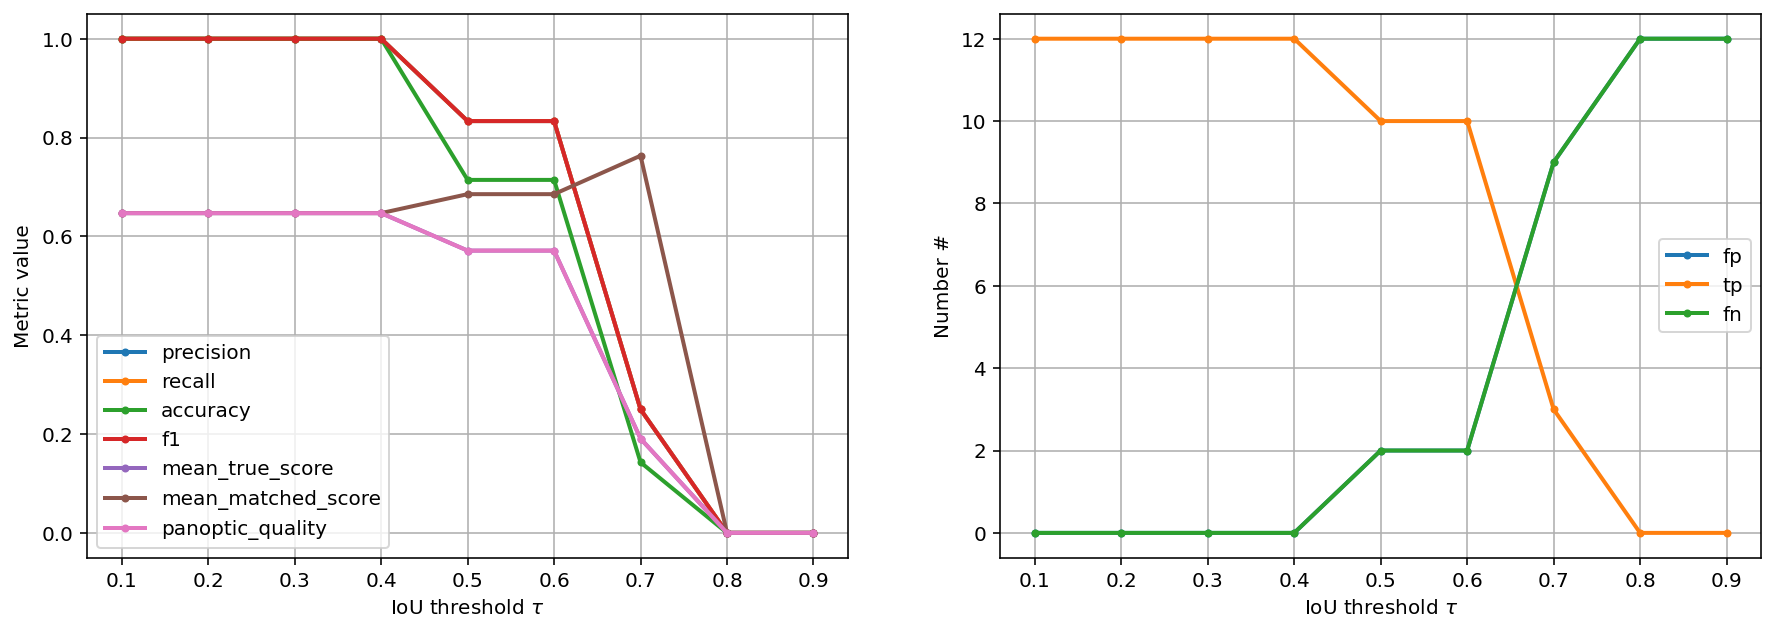

In [37]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();